# 预测茅台股票日k线开盘价

### 时间：2010-4-26到2020-4-26

- #### SimpleRNN
    - 均方误差: 4064.275347
    - 均方根误差: 63.751669
    - 平均绝对误差: 59.360274
- #### LSTM
    - 均方误差: 3084.904418
    - 均方根误差: 55.541916
    - 平均绝对误差: 49.045534
- #### GRU    
    - 均方误差: 1743.493806
    - 均方根误差: 41.755165
    - 平均绝对误差: 36.362571

In [3]:
# 获取k线数据
import tushare as ts
import matplotlib.pyplot as plt

# D=日k线
df1 = ts.get_k_data('600519', ktype='D', start='2010-04-26', end='2020-04-26')
df1
# datapath1 = "./SH600519.csv"
# df1.to_csv(datapath1)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


,date,open,close,high,low,volume,code
74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...
2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


## 1. SimpleRNN

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Epoch 1/50
33/33 [==============================] - 2s 23ms/step - loss: 0.2396 - val_loss: 0.0434
Epoch 2/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0311 - val_loss: 0.0044
Epoch 3/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0155 - val_loss: 0.0036
Epoch 4/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0115 - val_loss: 0.0131
Epoch 5/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 6/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0079 - val_loss: 0.0026
Epoch 7/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0073 - val_loss: 0.0187
Epoch 8/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 9/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 10/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 11/

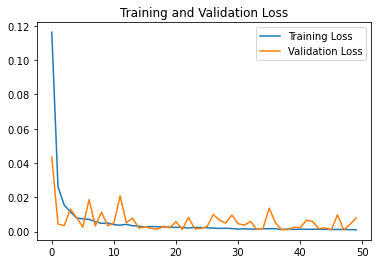

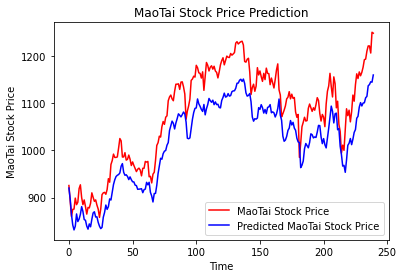

均方误差: 4064.275347
均方根误差: 63.751669
平均绝对误差: 59.360274


In [160]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  
# 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，
# 2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；
# 输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 
# 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_test，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    # 一般最后一层的循环核用False，仅在最后一个时间步输出ht(默认)；中间的层循环核用True，每个时间步都把ht输出给下一层。
    SimpleRNN(80, return_sequences=True),# 80个记忆体的循环核
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/SimpleRNN_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,#只保留模型参数
                                                 save_best_only=True,# 只保留最优结果
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])#validation_freq 每多少次epoch迭代使用测试集验证一次结果

model.summary()

file = open('./SimpleRNN_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

## 2. LSTM

Epoch 1/50
33/33 [==============================] - 4s 58ms/step - loss: 0.0331 - val_loss: 0.0493
Epoch 2/50
33/33 [==============================] - 2s 45ms/step - loss: 0.0016 - val_loss: 0.0140
Epoch 3/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 4/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0012 - val_loss: 0.0204
Epoch 5/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 6/50
33/33 [==============================] - 2s 47ms/step - loss: 9.9358e-04 - val_loss: 0.0061
Epoch 7/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 8/50
33/33 [==============================] - 2s 47ms/step - loss: 9.6675e-04 - val_loss: 0.0129
Epoch 9/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0157
Epoch 10/50
33/33 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0161
E

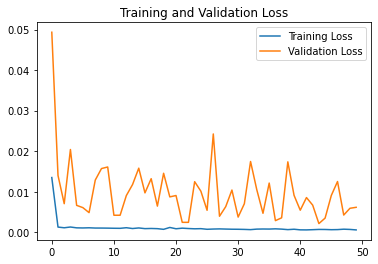

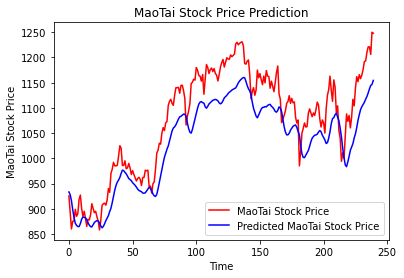

均方误差: 3084.904418
均方根误差: 55.541916
平均绝对误差: 49.045534


In [161]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  
# 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，
# 2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./LSTM_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

## 3. GRU

Epoch 1/50
33/33 [==============================] - 3s 52ms/step - loss: 0.0467 - val_loss: 0.0133
Epoch 2/50
33/33 [==============================] - 2s 48ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 3/50
33/33 [==============================] - 2s 49ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 4/50
33/33 [==============================] - 2s 49ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 5/50
33/33 [==============================] - 2s 49ms/step - loss: 9.9816e-04 - val_loss: 0.0016
Epoch 6/50
33/33 [==============================] - 2s 49ms/step - loss: 8.6051e-04 - val_loss: 0.0023
Epoch 7/50
33/33 [==============================] - 2s 48ms/step - loss: 9.2776e-04 - val_loss: 0.0015
Epoch 8/50
33/33 [==============================] - 2s 48ms/step - loss: 8.9080e-04 - val_loss: 0.0034
Epoch 9/50
33/33 [==============================] - 2s 49ms/step - loss: 9.5172e-04 - val_loss: 0.0020
Epoch 10/50
33/33 [==============================] - 2s 50ms/step - loss: 9.0934e-04 - va

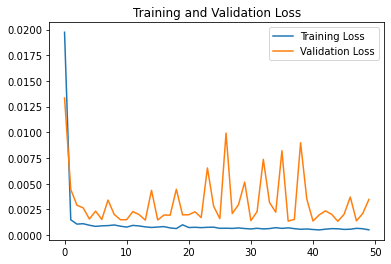

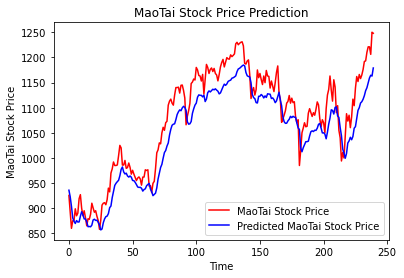

均方误差: 1743.493806
均方根误差: 41.755165
平均绝对误差: 36.362571


In [162]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/GRU_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./GRU_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)